## Credit
The exercise is based on material from the course _Deep Learning for Visual Recognition_.
https://kursuskatalog.au.dk/da/course/93556/Deep-Learning-for-Visual-Recognition

# Lab 4: Training neural networks
In this lab we will explore different tools that will help you to train your own neural networks.

We will be using fully connected networks.

## 1. Download the CIFAR 10 dataset
We will be using the CIFAR 10 dataset.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

# Batch size
bs = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Display some stats

num_train 50176
num_test 10240
images.shape torch.Size([256, 3, 32, 32])
images.min() tensor(0.)
images.max() tensor(1.)


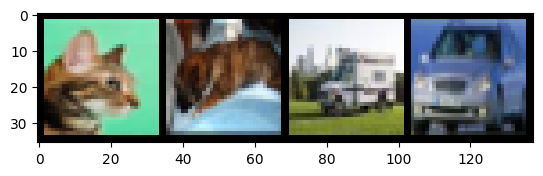

  cat   dog truck   car


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.shape',images.shape)
print('images.min()',images.min())
print('images.max()',images.max())

# show 4 images
imshow(torchvision.utils.make_grid(images[0:4]))

# print 4 labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Questions
1. What is the batch size?
2. What is the size of the images?
3. What is the range of the pixel intensities?

## Setting up device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:',device)

Device: cuda


## 2. Preprocessing

In the transformer the input is scaled to range -1 to 1.
The normalization is `(input[channel] - mean[channel]) / std[channel]`, where parameters (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) imply that the mean and standard deviation is set to 0.5 for all channels. See documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize). When reading the images from disk, the intensities are in the range 0 to 1. After normalization - and with these parameters - the output intensities will be in the range -1 to 1.


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Your code goes here

# Re-initialize trainloader and testloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

# Verify that intensities are in range -1 to 1
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.min()',images.min())
print('images.max()',images.max())

Files already downloaded and verified
Files already downloaded and verified
images.min() tensor(-1.)
images.max() tensor(1.)


### Questions
Below you are going to initialize and normalize the network weights based. To prepare for this task, answer the following questions using appropriate PyTorch functions (use Google to figure out which):
1. What is the mean and standard deviation (std) of tensor `x` below?
2. What is the mean and std `y`?
3. What is the mean and std `z`?

In [ ]:
x = torch.randn(512, 512)
y = x * 10 + 2
z = (y-2) / 10

## 3. Base model
We'll first create a base model that we can use for our initial experiments. The base model is a fully connected neural network. By default it has

- `L = 10` layers
- `N = 16` units in each hidden layer.

When initializing the model you can specify

- a `normalizer` function, which is applied when initializing the weight matrix `W` of each layer. The input to the normalizer functions is `W` and the output is some normalized version of `W`, like Xavier or Kaiming.

- an `activation_function` which could be sigmoid, tanh, ReLu, etc.

- a `preprocess_function` which is applied in each layer after calculating `Wx+b` but before applying the activation function. It can be used to implement batch normalization.

Initially we set all these functions to the identity function. In other words, the base model is a purely linear model without any activation functions, normalization or anything like that.

In [ ]:
from torch import nn

def base_normalizer(x): return x
def base_activation(x): return x
def base_preprocess(x): return x

class BaseModel(nn.Module):
    def __init__(self,
                 normalizer = base_normalizer,
                 activation_function = base_activation,
                 preprocess_function = base_preprocess,
                 L = 10,
                 N = 16):

        super().__init__()

        self.W = nn.ParameterList() # List of weights
        self.b = nn.ParameterList() # List of biases
        self.L = L # Number of layers
        self.N = N # Number of units in each hidden layer
        self.activation_function = activation_function
        self.preprocess_function = preprocess_function
        self.layer_activations = [] # Store layer activations here

        # Initialize weights and biases
        for layer in range(L):
          dims = [self.N, self.N] # Size of hidden layer
          if layer == 0: dims = [32*32*3,N] # Size of first layer
          if layer == L-1: dims = [N,10] # Size of last layer
          W = nn.Parameter(normalizer(torch.randn(dims[0], dims[1]))) # Call normalizer here
          b = nn.Parameter(torch.zeros(dims[1]))
          self.W.append(W)
          self.b.append(b)

    # Forward propagation
    def forward(self, x):
        self.layer_activations = []
        x = x.view(-1, 32*32*3) # Vectorize image to a 32*32*3 dimensional vector
        for layer in range(self.L):
          x = x @ self.W[layer] + self.b[layer]
          x = self.preprocess_function(x) # Call preprocess function before activation
          x = self.activation_function(x)
          self.layer_activations.append(x) # Store activations
        return x

    # Return stored layer activations
    def activations(self):
        return self.layer_activations

### 3.1 Test the model
Let's test the model:

In [ ]:
# Move data to GPU
images = images.to(device)
labels = labels.to(device)

# Calculate scores
model = BaseModel().to(device)
scores = model(images)  # predictions

print(scores.shape)

### 3.2 Calculating the accuracy
These numbers are scores (logits), which don't have any meaningful interpretation. We can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside the function `accuracy` that calculates the accuracy on a batch:

In [ ]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

### Question
1. What does `torch.argmax` do?

### 3.3 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss [already provided in PyTorch](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy). Note that `cross_entropy` does the softmax for you, so the input is just the scores.

In [ ]:
import torch.nn.functional as F
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

### 3.4 Getting layer activations and gradients
One special ting about our model is that it stores the activations after each layer (in variable `self.layer_activations`).

Our goal is develop tools that we can use to inspect our model both before and during training. For this purpose it will be useful to be able to grab the layer activations as well as the gradients at each layer. The activations have alreay been stored during our forward propagation and can be extracted as follows:

In [ ]:
activations = model.activations()
print('Activation list length:',len(activations))
print('Activations shape layer 1:',activations[0].shape)

To get the gradients w.r.t. the loss, first call `loss.backward()` and then access the `grad` property of the relevant model parameters.

In [ ]:
# Calculate gradients
loss.backward()

*Side-note:* If you are interested in understanding in detail how `backward()` works, I recommend [this blog post](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95).

Since we are going to need both the layer activations and layer-wise gradients, lets wrap that up in a single function:

In [ ]:
def get_layer_data(model):
  gradients = []
  layer_names = []

  with torch.no_grad():
    for name, param in model.named_parameters():
      if param.requires_grad and name.startswith('W'):
          layer_names.append(name)
          gradients.append(param.grad)

  activations = model.activations()

  return layer_names, activations, gradients

layer_names, activations, gradients = get_layer_data(model)
print('layer_names',layer_names)
print('Activation list length:',len(activations))
print('Activations shape layer 1:',activations[0].shape)
print('Gradient list length:',len(gradients))
print('Gradient shape layer 1:',gradients[0].shape)

Note that we are not considering the biases in this Lab.

### Questions
1. Why is the shape of the activations of the first layer [256,16]?
2. Why is the shape of the gradients of the first layer [3072,16]?


### 3.5 Getting layer stats
We can create a simple function that calculates the mean and the variance of the layer activations and gradients. For the gradients, we are interested in the *gradient flow*, so we will take the mean of the absolute gradient values.

In [ ]:
def get_layer_stats(x,absolute=False):
  avg = []
  std = []
  for layer in range(len(x)):
    if absolute:
      avg.append(x[layer].abs().mean().detach().cpu().numpy())
    else:
      avg.append(x[layer].mean().detach().cpu().numpy())

    std.append(x[layer].std().detach().cpu().numpy())

  return avg, std

activation_mean, activation_std = get_layer_stats(activations)
gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)

print('activation_mean:\n',activation_mean,'\n')
print('activation_std:\n',activation_std,'\n')
print('gradient_mean:\n',gradient_mean,'\n')
print('gradient_std:\n',gradient_std)

### 3.6 Visualizing layer stats
This is perhaps not very useful, so lets make a function that allows to plot histograms (and display mean and standard deviation at the same time).

Note that you can specifiy a fixed range of x values (like -1 to 1). If set to `None` the x range is adapted to each individual plot. So notice the values on the x-axis.

In [ ]:
def plot_hist(hs,xrange=(-1,1),avg=None,sd=None):
  plt.figure(figsize=(20,3))
  for layer in range(len(hs)):
    plt.subplot(1,len(hs),layer+1)
    activations = hs[layer].detach().cpu().numpy().flatten()
    plt.hist(activations, bins=20, range=xrange)

    title = 'Layer ' + str(layer+1)
    if avg:
      title += '\n' + "mean {0:.2f}".format(avg[layer])
    if sd:
      title += '\n' + "std {0:.4f}".format(sd[layer])

    plt.title(title)

print('Gradients:\n')
plot_hist(gradients,xrange=None,avg=gradient_mean,sd=gradient_std)
plt.show()

print('Activations:\n')
plot_hist(activations,xrange=None,avg=activation_mean,sd=activation_std)
plt.show()


### Questions
Carefully inspect the histograms above, and remember that the x-axes can be scaled differently.
1. What happens to the gradients across layers? How are they distributed? Do they get smaller or larger towards the end of the network?
2. What about the activations?

### 3.7 Wrapping up
Finally, let's combine all of the above into just one function that we can call. To do this we first define a helper function `get_stats` which takes a model as input, runs a batch trough the model, and calculates all the stats that we need.

In [ ]:
def get_stats(model,dataloader=trainloader):

  dataiter = iter(dataloader)
  images, labels = dataiter.next()
  images = images.to(device)
  labels = labels.to(device)

  scores = model(images)  # predictions
  loss = loss_func(scores, labels)
  acc = accuracy(scores,labels)

  # Calculate gradients
  loss.backward()

  layer_names, activations, gradients = get_layer_data(model)

  activation_mean, activation_std = get_layer_stats(activations)
  gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)

  stats = {'loss': loss,
           'accuracy': acc,
           'names': layer_names,
           'grads': gradients,
           'activations': activations,
           'activation_mean': activation_mean,
           'activation_std': activation_std,
           'gradient_mean': gradient_mean,
           'gradient_std': gradient_std
           }

  return stats

Here is the function to display the stats:

In [ ]:
def show_stats(stats):
  print('loss',stats['loss'].detach().cpu().numpy())
  print('accuracy',stats['accuracy'].detach().cpu().numpy(),'\n')

  print('Gradients:\n')
  print(' (note that we use the mean of the absolute gradient values to quantify gradient flow\n')
  #[print(name, avg, std) for name, avg, std in iter(zip(stats['names'],stats['gradient_mean'],stats['gradient_std']))]

  plot_hist(stats['grads'],xrange=None,avg=stats['gradient_mean'],sd=stats['gradient_std'])
  plt.show()

  print('Activations:\n')
  #[print(name, avg, std) for name, avg, std in iter(zip(stats['names'],stats['activation_mean'],stats['activation_std']))]

  plot_hist(stats['activations'],xrange=None,avg=stats['activation_mean'],sd=stats['activation_std'])
  plt.show()

So from now on we just make these two function calls:

In [ ]:
# Calculate stats
stats = get_stats(model)

# Show stats
show_stats(stats)

## 4. Task 1: tanh activation
Your task is very simple: Add tanh activation function to our base model and explain what you see. You can find inspiration [here](https://pytorch.org/docs/stable/generated/torch.tanh.html).

In [ ]:
def tanh(x):
  # Your code goes here
  return

model_tanh = BaseModel(activation_function=tanh).to(device)
stats = get_stats(model_tanh)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?
2. Is there gradient flow through the entire network?
3. Do the activations have similar variance across layers?
4. Are we within the linear range of tanh, within the saturated range, or a little of both?

## 5. Task 2: Increase values of initial weights
In our base model the weights are initialized with random values from a standard normal disitrbution (mean 0 and standard deviation 1). Let's increase the std to 10 and see what happens. Note that we keep using tanh acivation.

In [ ]:
def upscale(x): return x * 10

model_saturated = BaseModel(normalizer=upscale, activation_function=tanh).to(device)
stats = get_stats(model_saturated)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?
2. Is there gradient flow through the entire network?
3. Do the activations have similar variance across layers?
4. Are we within the linear range of tanh, within the saturated range, or a little of both?

## 6. Task 3: ReLu and Kaiming initialization
Your task is to change the activation function to ReLU, which is faster than tanh and doesn't suffer from vanishing gradients.

We will also use Kaiming weight initialization.
You can check PyTorch's Kaiming formula [here](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) (again, recall that fan-in is the number of columns of the weight matrix).

For ReLU you could use PyTorch's `F.relu` function. for kaiming, you could use `torch.nn.init.kaiming_normal_`

In [ ]:
model_kaiming = BaseModel(normalizer=YOUR_CODE_HERE, activation_function=YOUR_CODE_HERE).to(device)
stats = get_stats(model_kaiming)
show_stats(stats)

## 7. Task 4: Batch normalization
Finally, see if you can implement simple batch normalization (without the learnable parameters) by passing on a preprocessing function to our model. The input to the preprocess function is the result of multiplying layer input `x` with weight matrix `W` and adding the biases: That is: `y = Wx+b`. The output should be `z = (y - mean(y)) / std(y)`. In real batch normalization, we train a scaling parameter, $\gamma$, and a bias parameter, $\beta$, but for now, we will leave out $\gamma$ and $\beta$.

Hint: You can call `.mean()` and `.std()` on a tensor to get the mean and standard deviation, respectively. Remember to specify the correct dimensions.


In [ ]:
def batch_norm(y):
  # Your code goes here
  mu = y.mean(dim=0)
  var = y.var(dim=0)
  sigma = torch.sqrt(var + 1e-5)
  z = (y - mu)/sigma
  return z

In [ ]:
# Check your results
y = torch.randn(512,512)*10 + 2
print('before', y.mean(),y.std())
z = batch_norm(y)
print('after', z.mean(),z.std())

In [ ]:
model_batchnorm = BaseModel(normalizer=kaiming, activation_function=tanh,preprocess_function=batch_norm).to(device)
stats = get_stats(model_batchnorm)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?
2. Is there gradient flow through the entire network?
3. Do the activations have similar variance across layers?

Try replacing the tanh activation with Relu

4. Do enough of the ReLUs get activated in all layers?

Compare to the results with ReLu and tanh (without batch norm).


## 8. Model training
The code below can be used to train a model and monitor important stats as training progresses.

The training is carried out by calling the `fit` function, which takes a model as input, as well as a function handle returning an optimizer. The base optimizer is just SGD with zero momentum.

In addition, `lr` is the learning rate, `bs` the batch size, and `epochs` the number of epochs.

(Note: the cpu/gpu copying and torch/numpy conversions could have been made nicer - sorry...)

In [ ]:
from torch import optim

# Function handle that returns an optimizer - in this case just a simple SGD without momentum
def base_optimizer(model,lr=0.1):
    return optim.SGD(model.parameters(), lr=lr,momentum=0.)

# Used to print gradients/activations as a function of time
def print_history(history,title=''):
  plt.figure()
  history = np.asarray(history)
  lines = []
  labels = []
  for i in range(history.shape[1]):
    l, = plt.plot(history[:,i])
    lines.append(l)
    labels.append('Layer ' + str(i+1))
  plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
  plt.title(title)

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr=0.1,
        bs=256,
        epochs=2):

  train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

  valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)

  opt = opt_func(model,lr) # Initialize optimizer

  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []
  activation_mean_history = []
  gradient_mean_history = []

  t = 1

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      pred = model(xb.to(device))
      loss = loss_func(pred, yb.to(device))

      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      loss.backward()

      layer_names, activations, gradients = get_layer_data(model)
      activation_mean, activation_std = get_layer_stats(activations)
      gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)
      activation_mean_history.append(activation_mean)
      gradient_mean_history.append(gradient_mean)

      opt.step()
      opt.zero_grad()

    # Validation loss and accuracy
    model.eval()
    with torch.no_grad():
        valid_acc = sum(accuracy(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t-1)
        if epoch == epochs-1:
          print('validation loss',valid_loss.detach().cpu().numpy())
          print('validation accuracy', valid_acc.detach().cpu().numpy())

  # Summary

  plt.figure()

  plt.plot(plot_time_train,train_loss_history)
  plt.plot(plot_time_valid,valid_loss_history)

  plt.title('Loss')

  print_history(activation_mean_history,'Layer activations (mean)')
  print_history(gradient_mean_history,'Layer gradients (mean)')

  print('train loss',loss_func(model(xb.to(device)), yb.to(device)).detach().cpu().numpy())
  print('train accuracy', accuracy(model(xb.to(device)), yb.to(device)).detach().cpu().numpy())
  print('\n')
  plt.show()

### 8.1 Training the base model
Let's train the base model.

In [ ]:
model = BaseModel().to(device) # Re-initialize weights
fit(model,lr=1e-8)

stats = get_stats(model)
show_stats(stats)

### Questions
1. What is the validation accuracy?
2. What do the first three plots show?
3. What happened to the gradient flow over time? Did it increase, decrease, or stay constant?
4. What happens if you increase the learning rate to 0.1?

### 8.2 Training the tanh model
Recall that the base model is entirely linear (i.e., no activation functions used). Let's see what happens if we add tanh activations:

In [ ]:
model_tanh = BaseModel(activation_function=tanh).to(device) # Re-initialize weights
fit(model_tanh,lr=0.1)
stats = get_stats(model_tanh)
show_stats(stats)

### Questions
1. Did results improve significantly?
2. Are the activations within the linear range of tanh, within the saturated range, or a mix of both?
3. What happens to the gradients over time?

### 8.3 Could we possible do any worse?
Yes! Let's use a std of 10 when initializing the weights:

In [ ]:
model_saturated = BaseModel(normalizer=upscale, activation_function=tanh).to(device) # Re-initialize weights
fit(model_saturated,lr=0.1)
stats = get_stats(model_saturated)
show_stats(stats)

### Questions
1. What happens to the loss over time? Does it decrease?
2. It seems that there is almost no gradient signal. Why?

### 8.4 Kaming initialization
Now, let's see what happens with kaming initialization and ReLu:


In [ ]:
kaiming = torch.nn.init.kaiming_normal_
model_kaiming = BaseModel(normalizer=kaiming, activation_function=F.relu).to(device)
fit(model_kaiming,lr=0.1)
stats = get_stats(model_kaiming)
show_stats(stats)

### Questions
1. What happened to the validation accuracy?
2. What happens to the gradient signal over time?

### 8.5 Batch normalization
On average, results should become even better if we add batch normalization:

In [ ]:
model_batchnorm = BaseModel(normalizer=kaiming, activation_function=F.relu,preprocess_function=batch_norm).to(device)
fit(model_batchnorm,lr=0.1)
stats = get_stats(model_batchnorm)
show_stats(stats)

### Questions
1. Compare the curves with and without from the model with batch normalization (i.e., section 8.4 and 8.5). Can you explain the differences?

## 9. Optimizers
Below I have defined a few other optimizers (read more here: https://pytorch.org/docs/stable/optim.html). Your task is to experiment with these.

Suggestions:

1. Start with `momentum_optimizer` and train the model with momenum 0.0, 0.9, 0.99 and 1.0. Explain what happens.

2. Move on to experiment with Adagrad or RMSprop. Notice any different behavior?

3. Finally, try Adam with different learning rates. Theory says it shouldn't make a huge difference. Do your experiments confirm this?

In [ ]:
#SGD + momentum
def momentum_optimizer(model,lr=0.1):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9)

def adagrad_optimizer(model,lr=0.1):
  return optim.Adagrad(model.parameters(), lr=lr, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

def rmsprop_optimizer(model,lr=0.1):
  return optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

def adam_optimizer(model,lr=0.001):
  return optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

model = BaseModel(normalizer=kaiming, activation_function=F.relu,preprocess_function=batch_norm).to(device)
fit(model,opt_func=momentum_optimizer,lr=0.01,bs=64)

## 10. Competition
How high validation accuracy can you get in 5 epochs?

Rules - you are allowed to:
- modify the number of layers of the base model (parameter `L`).
- modify the unit in the hidden layers of the base model (parameter `N`).
- choose between different activation functions and normalizers
- use batch norm
- change the batch size
- use any optimizer and any optimization hyperparameters (e.g., learning rate)
- and **no more than 5 epochs!**

Think about your hyperparameter search strategy. What quick pre-experiments could you do before training the final model?

Can you reach over 50% accuracy???

In [ ]:
# Here is a baseline that you can compare with
model = BaseModel(normalizer=kaiming, activation_function=F.relu,preprocess_function=batch_norm,L=3,N=128).to(device)
fit(model,opt_func=adam_optimizer,lr=0.005,bs=256,epochs=5)

## 11. Optional
If you want a dataset, where you can achieve higher accuracy, try MNIST. Below are all the pieces you need to get started.

In [ ]:
from mlxtend.data import mnist_data
import random

X, y = mnist_data()
X = (X/255).astype(np.float32) # Convert to interval 0:1
y = y.astype(np.float32)
num_classes = 10
nchannels, rows, cols = 1, 28, 28

X = np.expand_dims(X.reshape(len(X),rows,cols),1) # Add a channel-dimension


def splitdata(X, y, Ngroups, weights=None):
    '''
    X, y = input data and labels
    Ngroups = number of groups to split data into
    weights = a list with Ngroups weights, that tell the probability of a sample ending in either of the data sets
    '''
    if weights is None:
        weights = [1/Ngroups]*Ngroups

    groups = np.array(random.choices(list(range(Ngroups)), weights=weights, cum_weights=None, k=len(X)))
    return ((X[np.where(groups==g)], y[np.where(groups==g)]) for g in np.array(range(Ngroups)))

(x_train, y_train), (x_valid, y_valid) = splitdata(X, y, Ngroups=2, weights=[0.9, 0.1])

In [ ]:
train_ds = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = torch.utils.data.TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs)

## 12. Batch normalization with learnable parameters
Just for fun :-)

In [ ]:
# Batch norm with learnable parameters gamma and beta
def batch_norm(y,gamma,beta):
  mu = y.mean(dim=0)
  var = y.var(dim=0)
  sigma = torch.sqrt(var + 1e-5)
  z = gamma*(y - mu)/sigma + beta
  return z

In [ ]:
# Batch norm without learnable parameters (they have
# to be there as input parameters, but they are not used).
def batch_norm_no_learn(y,gamma,beta):
  mu = y.mean(dim=0)
  var = y.var(dim=0)
  sigma = torch.sqrt(var + 1e-5)
  z = (y - mu)/sigma
  return z

In [ ]:
# Check results
y = torch.randn(32*32*3,16)*10 + 2
print('before', y.mean(),y.std())
gamma = torch.ones(16)
beta = torch.zeros(16)
z = batch_norm(y,gamma,beta)
print('after', z.mean(),z.std())
z = batch_norm_no_learn(y,gamma,beta)
print('after (no learn)', z.mean(),z.std())

### Model extension
Small extension of the model to enable learning of the batch norm parameters, gamma and beta.

In [ ]:
from torch import nn

def base_normalizer(x): return x
def base_activation(x): return x

# This is the modified base preprocessor that returns the identity.
# Only difference compared to above is that I have added two extra input
# parameters gamma and beta, which have to be here, but are not used
def base_preprocess(x,gamma,beta): return x

class BaseModel(nn.Module):
    def __init__(self,
                 normalizer = base_normalizer,
                 activation_function = base_activation,
                 preprocess_function = base_preprocess,
                 L = 10,
                 N = 16):

        super().__init__()

        self.W = nn.ParameterList() # List of weights
        self.b = nn.ParameterList() # List of biases
        self.beta = nn.ParameterList() # BatchNorm
        self.gamma = nn.ParameterList() # BatchNorm
        self.L = L # Number of layers
        self.N = N # Number of units in each hidden layer
        self.activation_function = activation_function
        self.preprocess_function = preprocess_function
        self.layer_activations = [] # Store layer activations here

        # Initialize weights and biases
        for layer in range(L):
          dims = [self.N, self.N] # Size of hidden layer
          if layer == 0: dims = [32*32*3,N] # Size of first layer
          if layer == L-1: dims = [N,10] # Size of last layer
          W = nn.Parameter(normalizer(torch.randn(dims[0], dims[1]))) # Call normalizer here
          b = nn.Parameter(torch.zeros(dims[1]))
          beta = nn.Parameter(torch.zeros(dims[1])) # NEW
          gamma = nn.Parameter(torch.ones(dims[1])) # NEW
          self.W.append(W)
          self.b.append(b)
          self.beta.append(beta) # NEW
          self.gamma.append(gamma) # NEW

    # Forward propagation
    def forward(self, x):
        self.layer_activations = []
        x = x.view(-1, 32*32*3) # Vectorize image to a 32*32*3 dimensional vector
        for layer in range(self.L):
          x = x @ self.W[layer] + self.b[layer]
          x = self.preprocess_function(x,self.gamma[layer],self.beta[layer]) # MODIFIED
          x = self.activation_function(x)
          self.layer_activations.append(x) # Store activations
        return x

    # Return stored layer activations
    def activations(self):
        return self.layer_activations

In [ ]:
# Move data to GPU
images = images.to(device)
labels = labels.to(device)

# Calculate scores
model = BaseModel().to(device)
scores = model(images)  # predictions

print(scores.shape)

### Test - tanh and without batch norm

In [ ]:
model_tanh = BaseModel(activation_function=tanh).to(device) # Re-initialize weights
fit(model_tanh,lr=0.1)
stats = get_stats(model_tanh)
show_stats(stats)

### Test - tanh with batch norm (with learnable parameters)

In [ ]:
model_tanh = BaseModel(activation_function=tanh,preprocess_function=batch_norm).to(device) # Re-initialize weights
fit(model_tanh,lr=0.1)
stats = get_stats(model_tanh)
show_stats(stats)

### Test - tanh with simple batch norm (without learnable parameters)

In [ ]:
model_tanh = BaseModel(activation_function=tanh,preprocess_function=batch_norm_no_learn).to(device) # Re-initialize weights
fit(model_tanh,lr=0.1)
stats = get_stats(model_tanh)
show_stats(stats)